In [63]:
import matplotlib.pyplot as plt


import geopandas as gpd
import gdal


import os
import sys

cur_dir = os.getcwd()
modulePath=os.path.join(cur_dir,os.pardir)

sys.path.insert(0,modulePath)
import raidnr.bwgrid.grid_transformations as gt
import raidnr.core.speed_curve as sc



sys.path.insert(0,modulePath)
import raidnr.bwgrid.grid_transformations as gt

import imp
import numpy as np

imp.reload(gt)
osPath=os.path.join(modulePath,"data","shp","OS","data")
shpPath=os.path.join(modulePath,"data","shp")

rasterPath=os.path.join(cur_dir,"results")

from shapely.geometry import Polygon

### Grid Reference Point

In [4]:
w3w="lunch.lofts.shirt"


square=gt.w3wGetCoordinates(w3w,returnFullResponse=True)['square']


corner_stone=gt.wgs_to_bng(list(square['southwest'].values()))


In [5]:
test=gt.get_UG_centroid_from_coords(corner_stone,corner_stone,3)

### Create grid and rasterize shp

#### Specify bbox from .shp


In [177]:
def fetchSHP(name,projection):
    directory=os.path.join(shpPath,name,projection)
    files=os.listdir(directory)
    for i in files:
        if i.split(".")[1]=="shp":
            return os.path.join(directory,i)

In [7]:
bbox_file_name=fetchSHP("bbox","BNG")
bbox_file= gpd.read_file(bbox_file_name)
bbox=gt.get_Bounds_FromShape(bbox_file)
# Tsection

# bbox=[414462.2503762188, 419685.2503762188, 417051.1119170117, 421998.1119170117]


bbox

[404090.6344816111, 411100.1071910278, 408361.4373172173, 414931.40906368574]

#### Predefined bbox

In [6]:
cur_dir = os.getcwd()
resultPath=os.path.join(cur_dir,"results","grid_creation")


# user defined
bbox = [407912.83459730295, 414116.4445978563, 414391.0912720474, 417003.13814145426]
test_bbox=Polygon([[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]]])


# save to gpd
bbox_gpd = gpd.GeoDataFrame(geometry=[test_bbox])
# reproject
bbox_gpd.crs = {'init' :'epsg:27700'}


# TODO maybe we can read directly
# align with the grid
NW,SE=gt.get_UG_grid_bounds(bbox_gpd,corners=True)

# adjust the new bounds
minx,maxy=NW[0][0],NW[1][0]
maxx,miny=SE[0][2],SE[1][2]

# same procedure, maybe wrap to a function
bbox=[minx,miny,maxx,maxy]
test_bbox=Polygon([[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]]])
bbox_gpd = gpd.GeoDataFrame(geometry=[test_bbox])
bbox_gpd.crs = {'init' :'epsg:27700'}

# export to shp
fileName=os.path.join(resultPath,"result2.shp")
bbox_gpd.to_file(fileName)



returning corners for NW and SE corner cells 


In [7]:
NW,SE=gt.get_UG_grid_bounds(bbox_gpd,corners=True)

returning corners for NW and SE corner cells 


In [8]:
minx,maxy=NW[0][0],NW[1][0]
maxx,miny=SE[0][2],SE[1][2]

bbox=[minx,miny,maxx,maxy]

test_bbox=Polygon([[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]]])

bbox_gpd = gpd.GeoDataFrame(geometry=[test_bbox])
bbox_gpd.crs = {'init' :'epsg:27700'}


fileName=os.path.join(resultPath,"result2.shp")
bbox_gpd.to_file(fileName)



In [18]:


dirPath = os.path.join(os.getcwd(),os.pardir,"flask_UI","InputData","shp","OS","data")
rasterPath = os.path.join(resultPath,"rasters")
shpTitles=[]
for i in os.listdir(dirPath):
    if(i.split(".")[1]=="shp"):     
        shpTitles.append(i.split(".")[0])
        filename=os.path.join(dirPath,i)
        rasterFile=os.path.join(rasterPath,i.split(".")[0]+".tif")
        array_raster=gt.rasterize_shape(filename,bbox,rasterFile)
        

### Read rasters / build cost surface


##### Read raster information from directory

In [100]:
import imp
imp.reload(gt)

<module 'raidnr.bwgrid.grid_transformations' from 'C:\\Users\\brydenwood\\Desktop\\test_projects\\19029_raid_nr\\notebooks_to_publish\\..\\raidnr\\bwgrid\\grid_transformations.py'>

In [59]:
rasterFile= os.path.join(rasterPath,os.listdir(rasterPath)[0])
ds = gdal.Open(rasterFile)
raster_size=(ds.RasterYSize,ds.RasterXSize)

print(" Raster dimensions",raster_size)

 Raster dimensions (965, 2162)


In [60]:
test_array,titles=gt.get_grid_from_directory(rasterPath,raster_size,use_TOPO_LAYERS=False)

In [70]:
sumarray = np.sum(test_array.transpose(2,0,1), axis=0, dtype=np.float64).squeeze() 


In [76]:
test_array.transpose(2,0,1).squeeze()

(25, 965, 2162)

##### Export cost surface as txt

In [50]:
np.savetxt('building_world_test.txt', testarray[:,:,0])

##### Accumulated cost surface


Bridges.tif


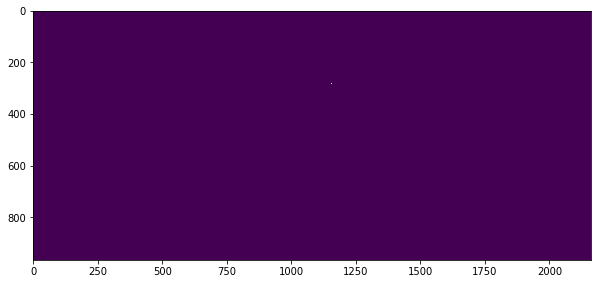

Building.tif


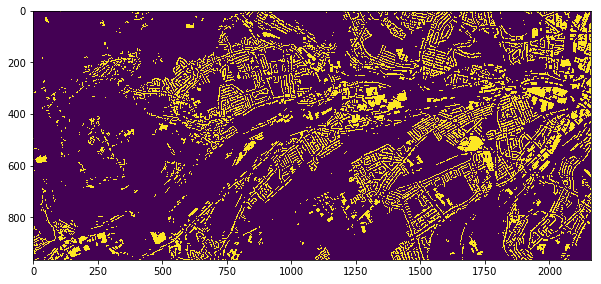

CarChargingPoint.tif


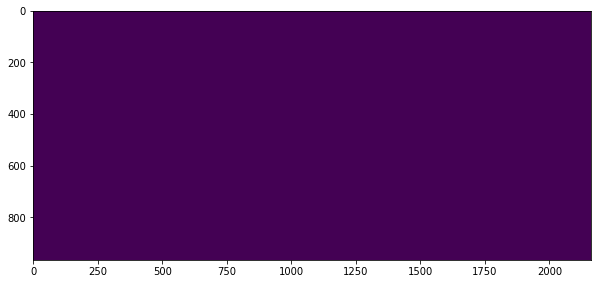

clipped.tif


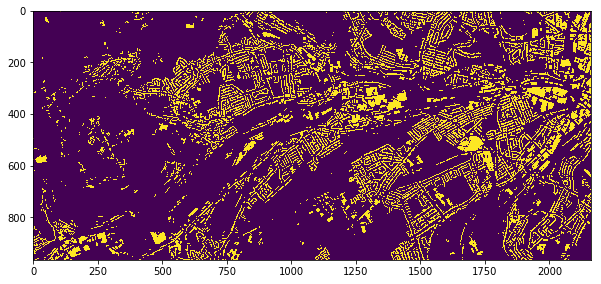

Foreshore.tif


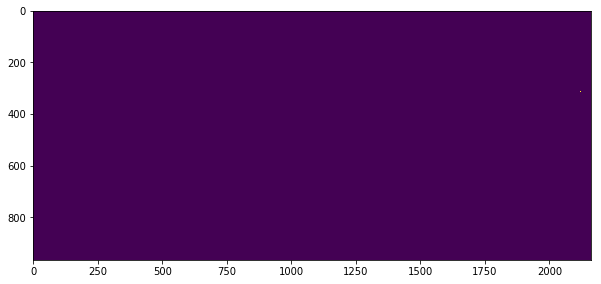

FunctionalSite.tif


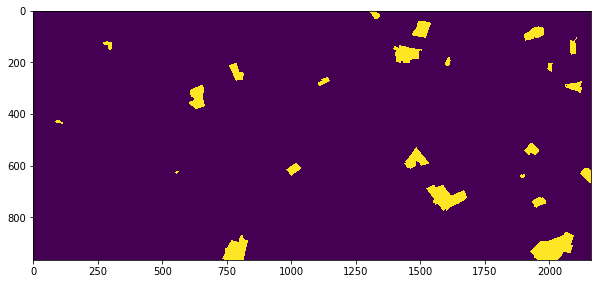

ImportantBuilding.tif


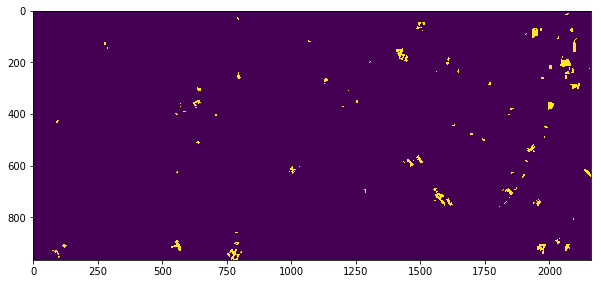

NamedPlace.tif


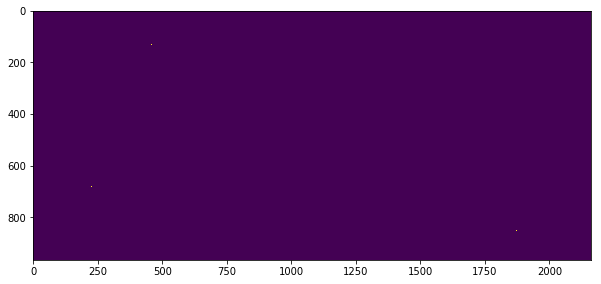

RailwayStation.tif


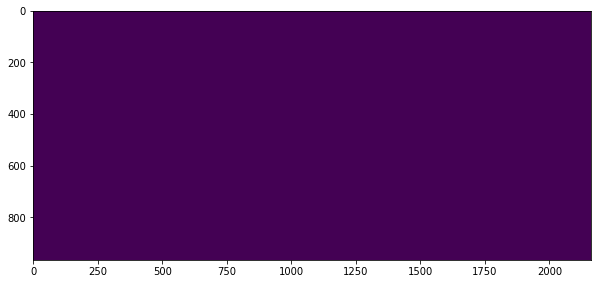

RailwayTrack.tif


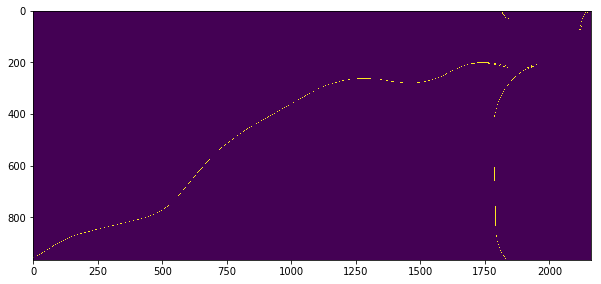

RailwayTunnel.tif


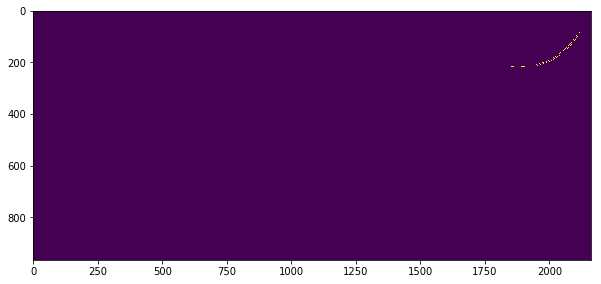

Road.tif


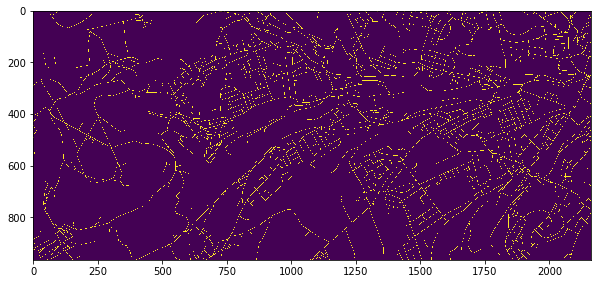

SurfaceWater_Area.tif


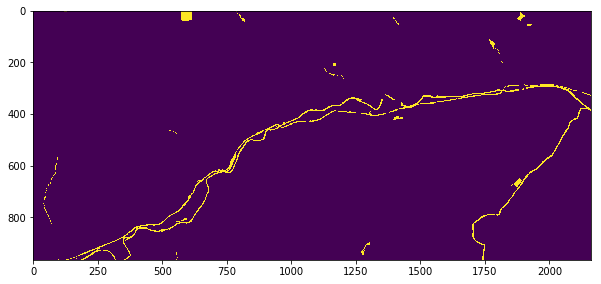

SurfaceWater_Line.tif


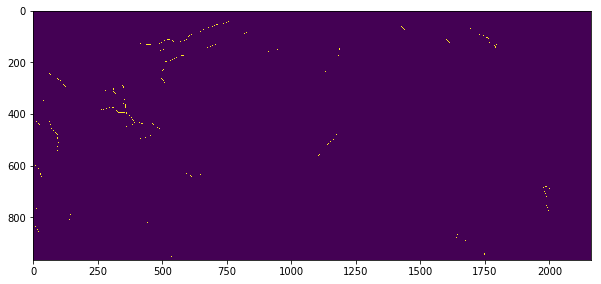

TidalWater.tif


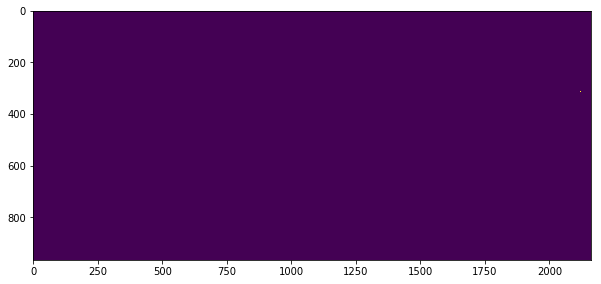

Woodland.tif


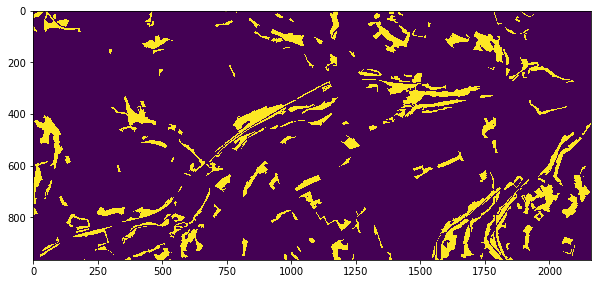

In [66]:
for number in range(len(titles)):
    
    if(np.sum(test_array[:,:,number])>0):
        
        fig,ax = plt.subplots(figsize=(10,5))

        print(titles[number])
        plt.imshow(test_array[:,:,number])
        plt.show()

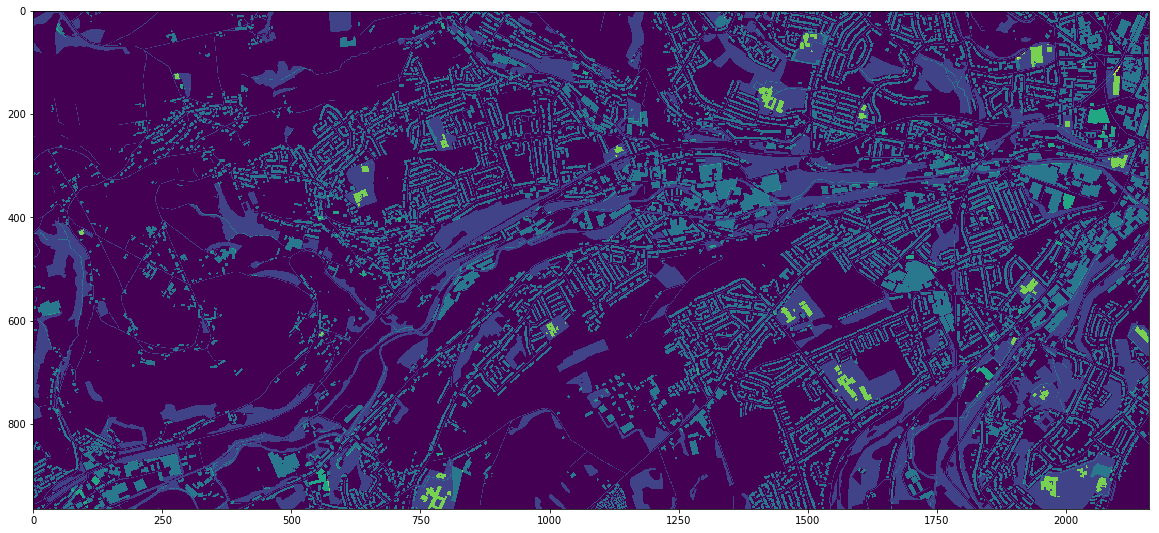

In [85]:
fig,ax = plt.subplots(figsize=(20,20))

plt.imshow(sumarray)
plt.show()

### Integration with the w3words scheme

#####  Raster to W3Words

In [143]:
bng_coords=gt.raster_to_coords(bbox,(500,500))

wgs_coords=gt.bng_to_wgs(bng_coords)
w3w_grid=gt.w3wGetGrid(wgs_coords[1],wgs_coords[0])
print(w3w_grid['words'])

harp.cave.stands


#### Plot universal grid with w3w references

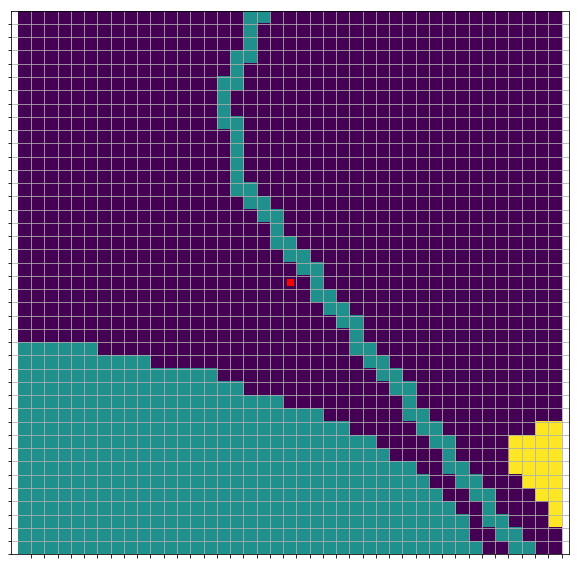

In [129]:
gt.return_plot_grid(sumarray,gt.coords_geo_to_raster(bbox,bng_coords),w=20)

(500, 500)


C:\Users\brydenwood\Desktop\test_projects\19029_raid_nr\notebooks_to_publish\..\raidnr\bwgrid\grid_transformations.py:740: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(cost_surface!=""):


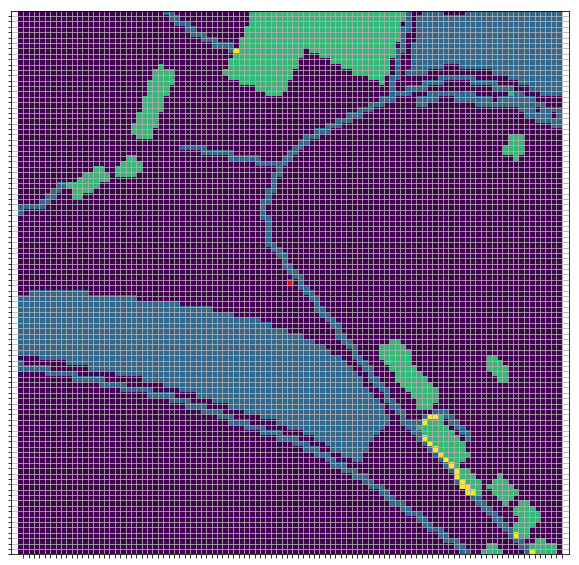

In [145]:
gt.w3w_to_raster(w3w_list="harp.cave.stands",bbox=bbox,plot=True,cost_surface=sumarray,w=50)